## PUI 2016 HOMEWORK 10, ASSIGNMENT 2
#### Ian Wright, iw453
#### November 2016

##### Variation of Lab9 - Spatial Data Analysis w/ Seasonality Comparison
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
from geopandas import GeoDataFrame
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

In [4]:
ct_shape.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
BoroCT2010,,,,,,,,,,,,
5000900,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,POLYGON ((-74.07920577013245 40.64343078374566...
5012500,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,POLYGON ((-74.11618948747538 40.62894119691981...
5013301,5013301,5,Staten Island,E,013301,133.01,SI22,West New Brighton-New Brighton-St. George,3903,7.217847e+05,3428.312676,POLYGON ((-74.11719947139957 40.63456809812987...
5019700,5019700,5,Staten Island,I,019700,197,SI07,Westerleigh,3903,3.231720e+06,9097.697226,POLYGON ((-74.13122302263596 40.61726518212697...
5002002,5002002,5,Staten Island,I,002002,20.02,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,8.501224e+06,12591.725901,"POLYGON ((-74.0635056566019 40.60215005483046,..."


### Coordinate systems, projections, and transformations 

In [5]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

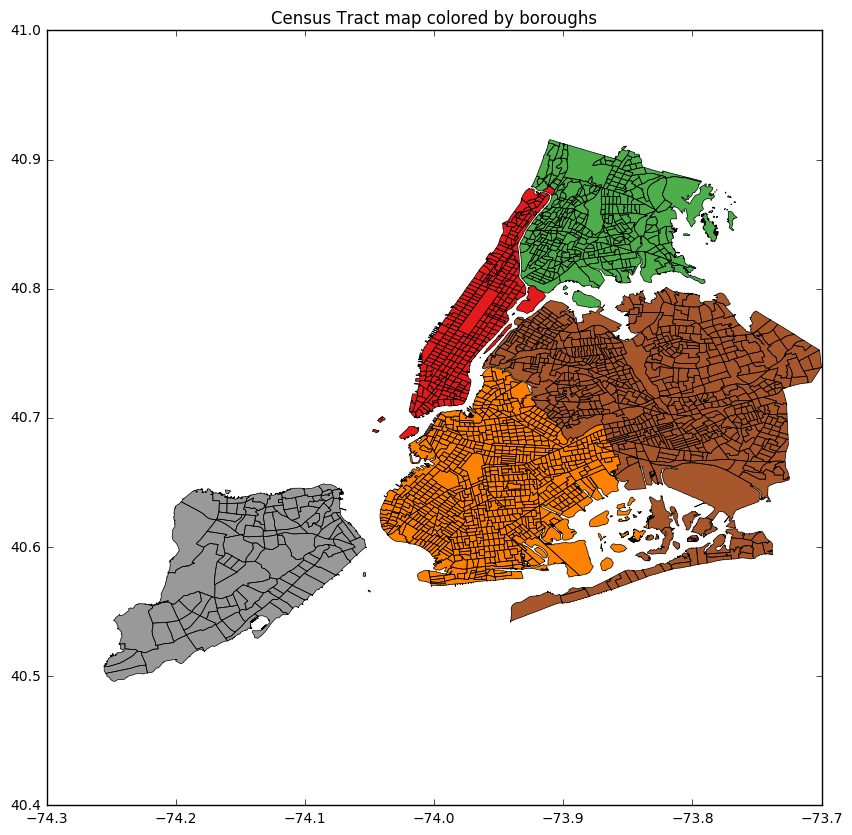

In [6]:
f, ax = plt.subplots(figsize=(10,10))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [7]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

 social explorer for free data

#### Add popuation density to CT shapefile

In [8]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/Users/ian/anaconda2/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


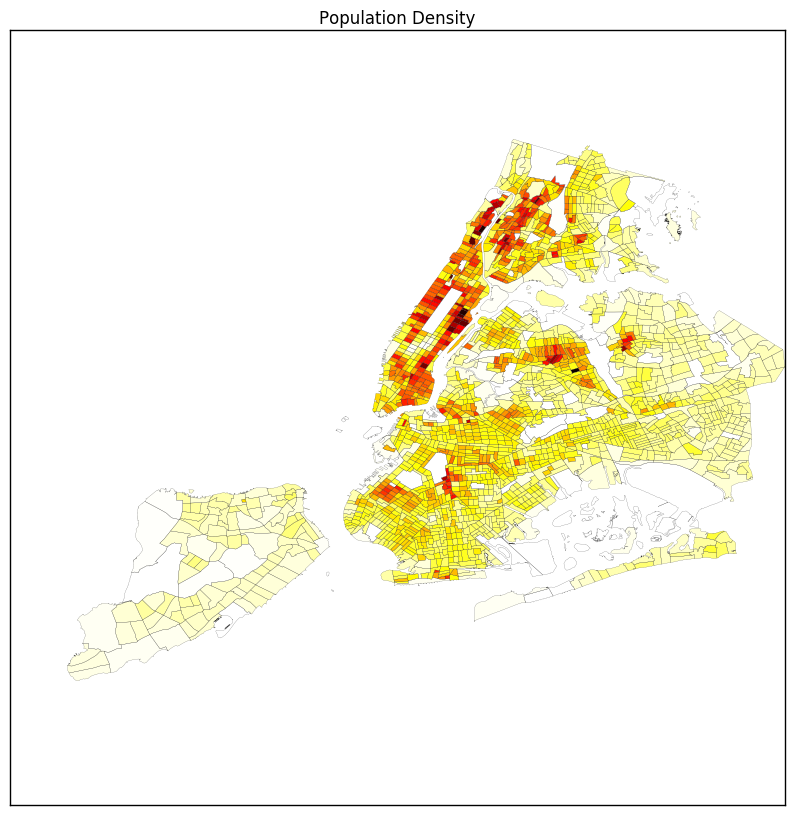

In [9]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data

In [86]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


In [87]:
def which_season(date):
    """
    function takes datetime as input;
    if date is during summer (May to September inclusive), return 1;
    if date is during winter (December to March inclusive), return 0;
    otherwise return np.nan
    """
    if date.month >= 5 and date.month <= 9:
        return 1
    elif date.month == 12 or date.month <= 3:
        return 0
    else:
        return np.nan

In [88]:
df_bike_monthly['season'] = df_bike_monthly.index.map(which_season)

In [89]:
df_bike_summer = df_bike_monthly[df_bike_monthly['season'] == 1]
df_bike_winter = df_bike_monthly[df_bike_monthly['season'] == 0]

### Time Series Analysis

/Users/ian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

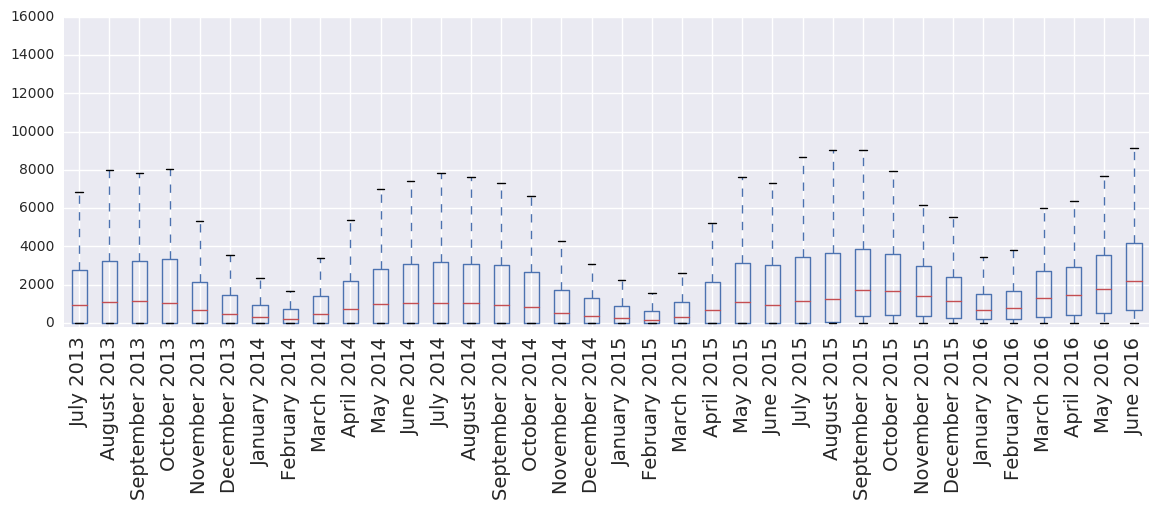

In [90]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Seasonal Decomposition

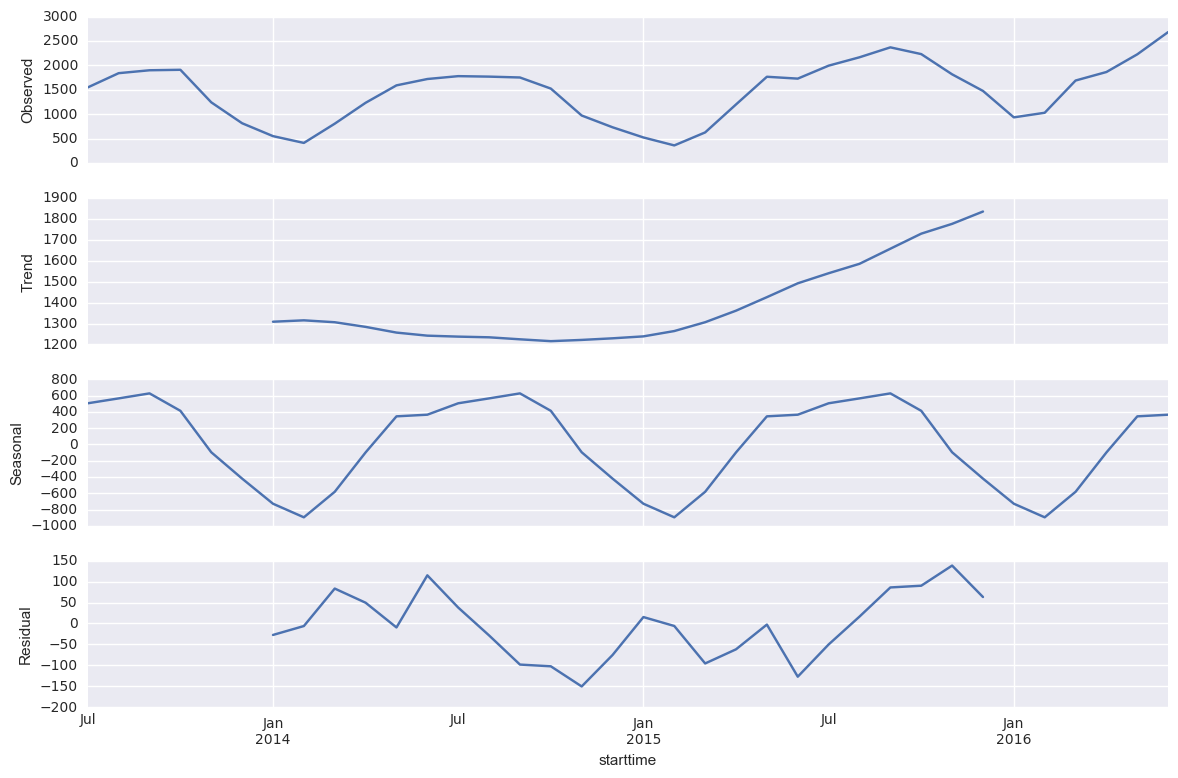

In [91]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [92]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [93]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [94]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [95]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

## *From this point on, the notebook forks into two parallel analyses: for summer and winter months*

### Add Monthly rides to the station GeoDataFrame with CT code

In [99]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['SummerAvg']=df_bike_summer.sum()
station_id['WinterAvg']=df_bike_winter.sum()

In [100]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,SummerAvg,WinterAvg
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,37184.0,13163.0
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,59241.0,16113.0
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,147418.0,52940.0
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,55867.0,19541.0
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,101767.0,31319.0


### Add the monthly average rides to the CT shapefile 

In [123]:
# join shapefiles with monthly counts of rides
temp = station_id[['SummerAvg']]
temp.loc[:, 'WinterAvg'] = station_id['WinterAvg']
temp.loc[:, 'station_id'] = station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve = ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/Users/ian/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ian/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/ian/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

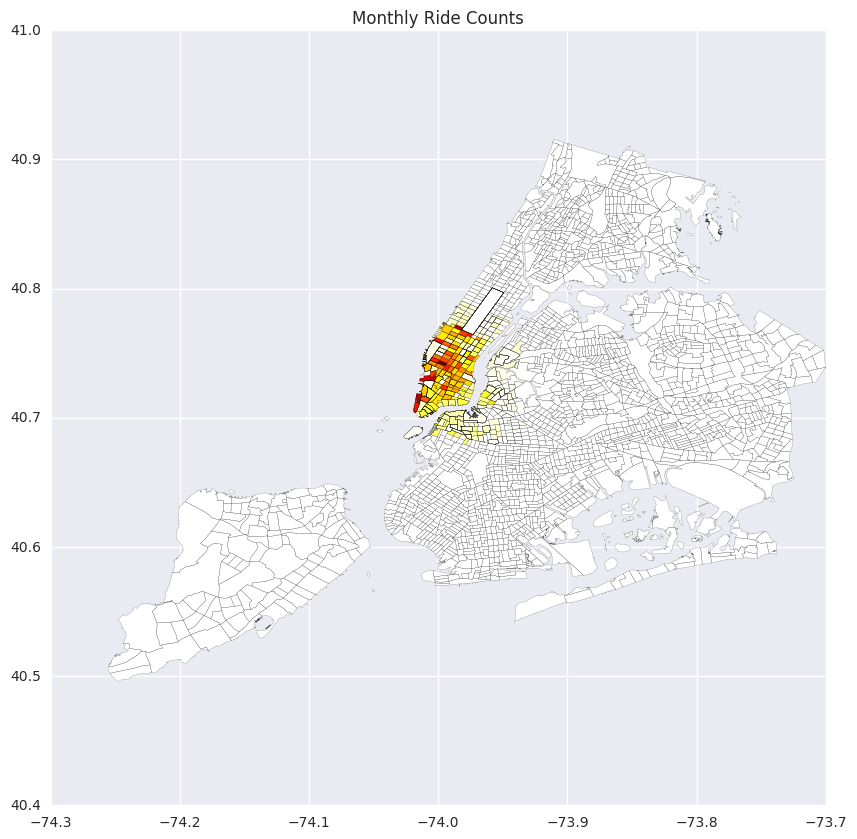

In [122]:
# plotting absolute summer rides
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='SummerAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Monthly Ride Counts")

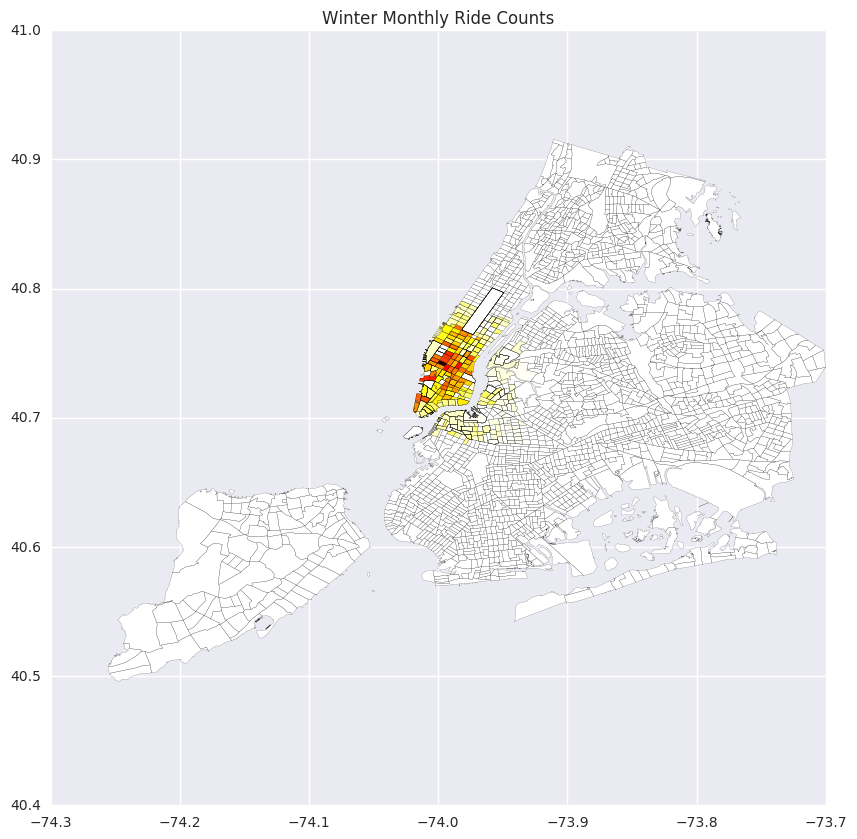

In [124]:
# plotting absolute winter rides
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='WinterAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Monthly Ride Counts")

### Removing the CTs that are out of zoom boundries

In [125]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [129]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.SummerAvg)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

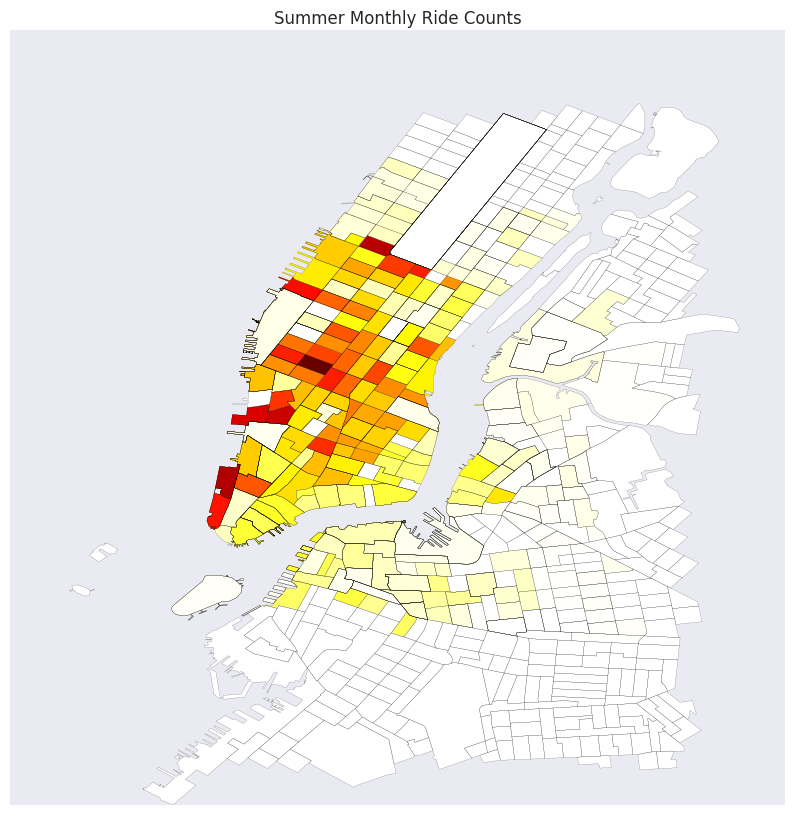

In [130]:
# mapping summer rides
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='SummerAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Monthly Ride Counts")

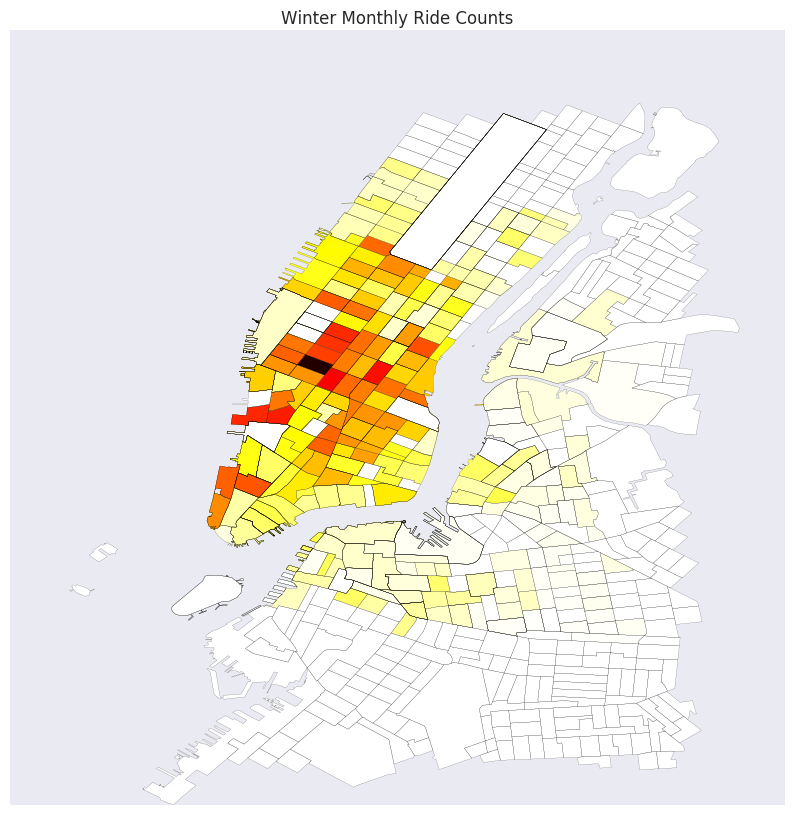

In [131]:
# mapping winter rides
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='WinterAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Monthly Ride Counts")

### Export Shapefile CTs in the CitiBike Zone

In [132]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [133]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [134]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [135]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [136]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [137]:
Wmatrix, ids = qW_CT.full()

In [138]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [139]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  (weighted average of neighbors, excluding self)
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [141]:
# spacial lag computation
SummerRide = ct_shape_MonthlyAve_Zoom.SummerAvg
WinterRide = ct_shape_MonthlyAve_Zoom.WinterAvg

SummerRideLag = ps.lag_spatial(qW_CT, SummerRide)
WinterRideLag = ps.lag_spatial(qW_CT, WinterRide)

#### Create Quantiles for maping

In [142]:
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
SummerRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               140
    0.000 < x[i] <=   118.714                21
  118.714 < x[i] <=  2001.200                78
 2001.200 < x[i] <=  4570.222                80
 4570.222 < x[i] <=  9678.596                79
 9678.596 < x[i] <= 14583.100                80
14583.100 < x[i] <= 31786.641                79
31786.641 < x[i] <= 45963.500                80
45963.500 < x[i] <= 53341.644                79
53341.644 < x[i] <= 81357.357                80

In [143]:
WinterRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    55.143                 2
   55.143 < x[i] <=   902.271                78
  902.271 < x[i] <=  2165.333                80
 2165.333 < x[i] <=  3452.913                79
 3452.913 < x[i] <=  5014.083                80
 5014.083 < x[i] <= 11249.113                79
11249.113 < x[i] <= 15205.882                80
15205.882 < x[i] <= 18477.420                79
18477.420 < x[i] <= 29902.786                80

#### Map the monthly rides lag

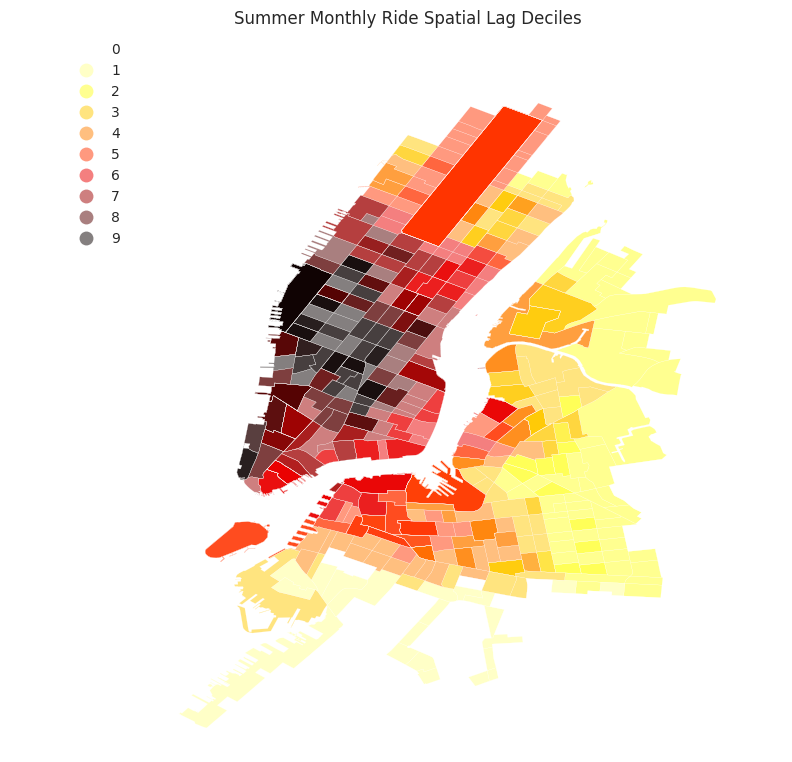

In [144]:
bf, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Monthly Ride Spatial Lag Deciles")

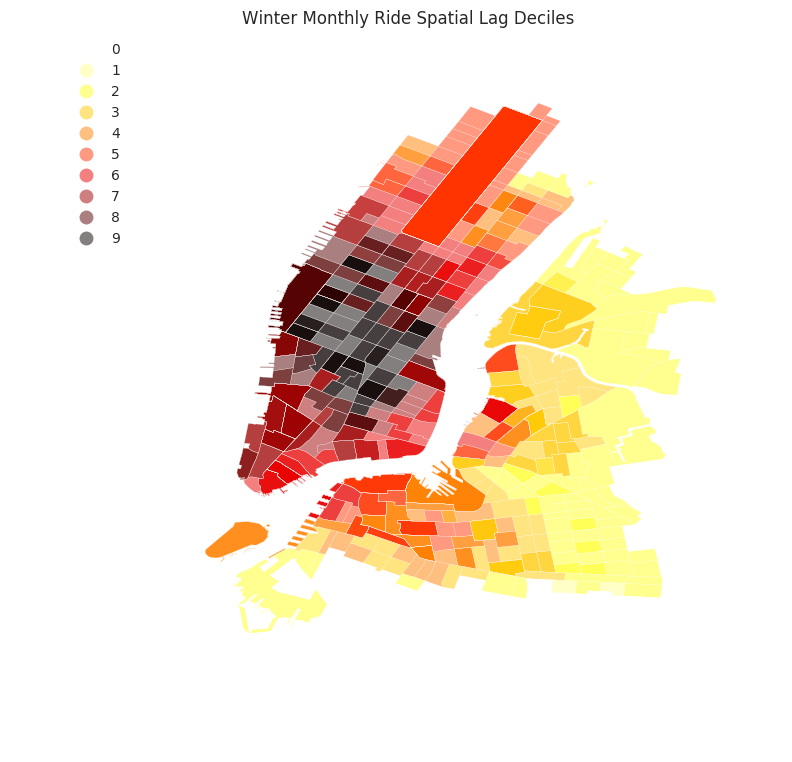

In [145]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Monthly Ride Spatial Lag Deciles")

## Global  Spatial Autocorrelation (SUMMER)

In [146]:
b,a = np.polyfit(SummerRide, SummerRideLag, 1)
b,a 

(0.64324972619372123, 7089.9409421288974)

### Moran Scatterplot

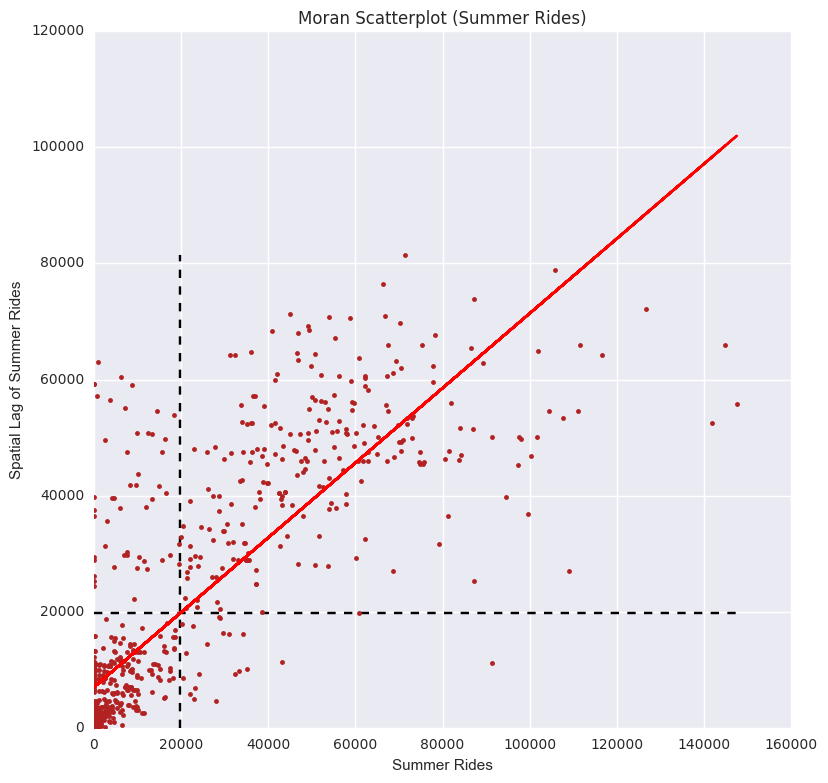

In [148]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(SummerRide, SummerRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a + b*SummerRide, 'r')
plt.title('Moran Scatterplot (Summer Rides)')
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Summer Rides')

### Moran's I

In [149]:
I_MonthlyRide = ps.Moran(SummerRide, qW_CT)

In [150]:
I_MonthlyRide.I, I_MonthlyRide.p_sim

(0.64341356964776641, 0.001)

Thus, the $I$ statistic is $0.643$ for this data, and has a very small $p$ value. 

In [151]:
I_MonthlyRide.sim[0:10]

array([-0.00219213,  0.01130818,  0.0048805 ,  0.01029045, -0.01972087,
        0.01495476, -0.01096593,  0.0023167 ,  0.00779707,  0.01037359])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [152]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

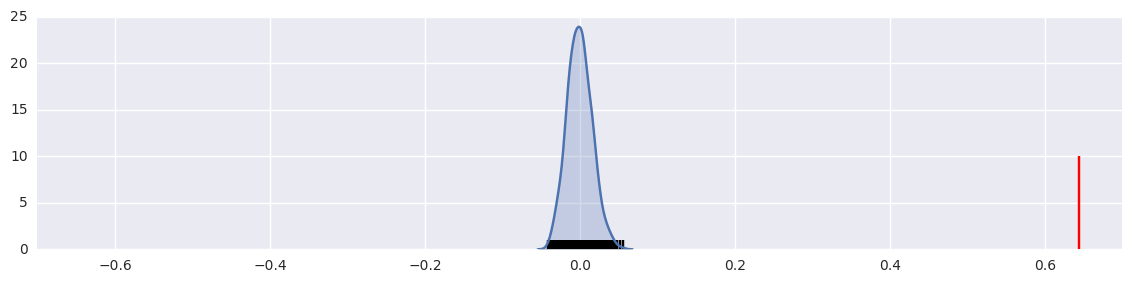

In [153]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

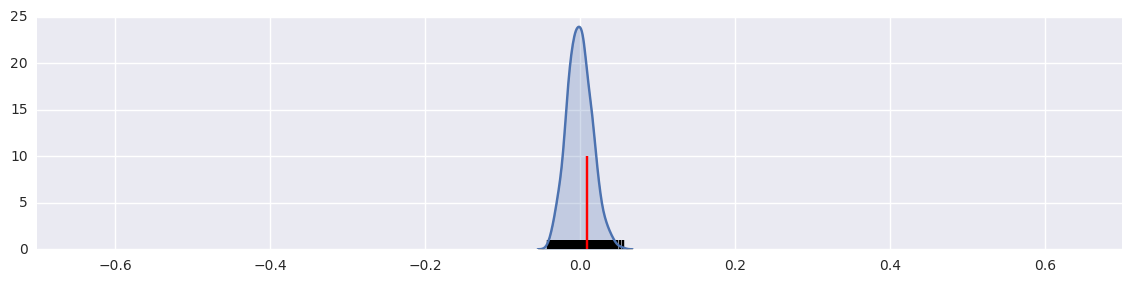

In [154]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [157]:
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT,permutations=999)

In [158]:
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.23886262,  0.01265189,  0.00397506,  0.02321185]),
 array([ 0.001,  0.174,  0.332,  0.336,  0.38 ]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [159]:
sigs = SummerRide[LMo_SummerRide.p_sim <= .001]
W_sigs = SummerRideLag[LMo_SummerRide.p_sim <= .001]
insigs = SummerRide[LMo_SummerRide.p_sim > .001]
W_insigs = SummerRideLag[LMo_SummerRide.p_sim > .001]

### Plot Signficant LISA

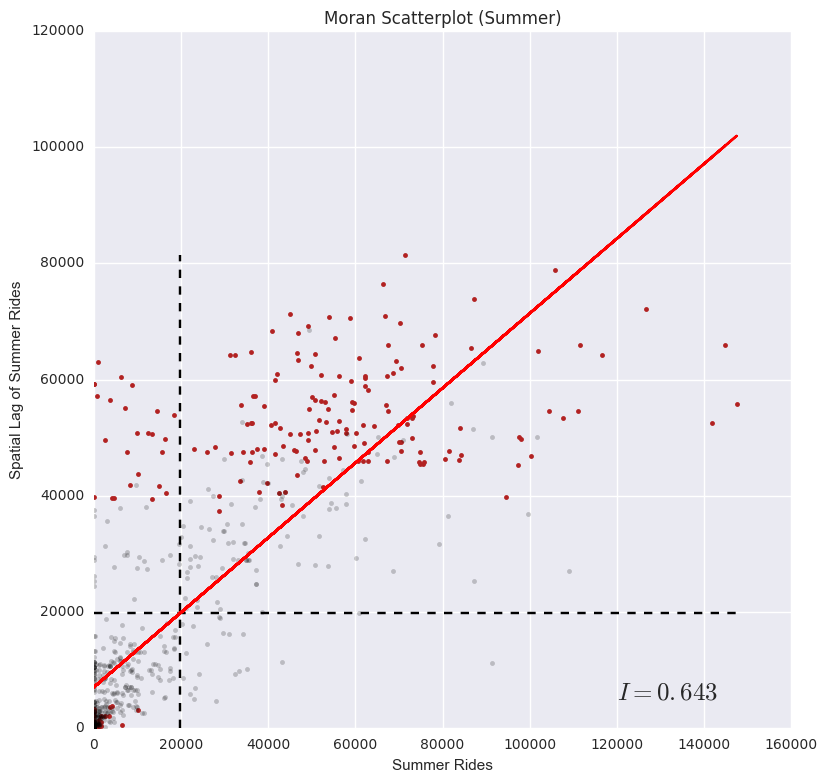

In [161]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a + b*SummerRide, 'r')
plt.title('Moran Scatterplot (Summer)')
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Summer Rides')


### Hot and Cold spots 

In [162]:
sig = LMo_SummerRide.p_sim < 0.01
hotspots = LMo_SummerRide.q==1 * sig
coldspots = LMo_SummerRide.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 189
Number of Coldspots: 241


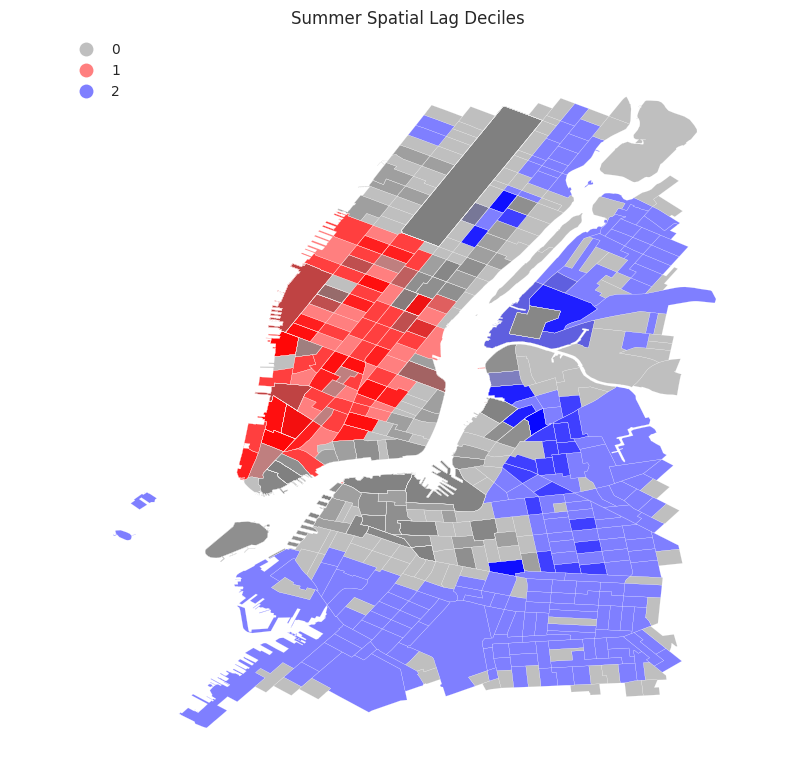

In [163]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Spatial Lag Deciles")

##### Figure 1: Local spacial autocorrelation for summer Citibike Rides; shown as hot spots and cold spots throughout New York City

## Global  Spatial Autocorrelation (WINTER)

In [164]:
b,a = np.polyfit(WinterRide, WinterRideLag, 1)
b,a 

(0.66189462250696818, 2331.8176412763351)

### Moran Scatterplot

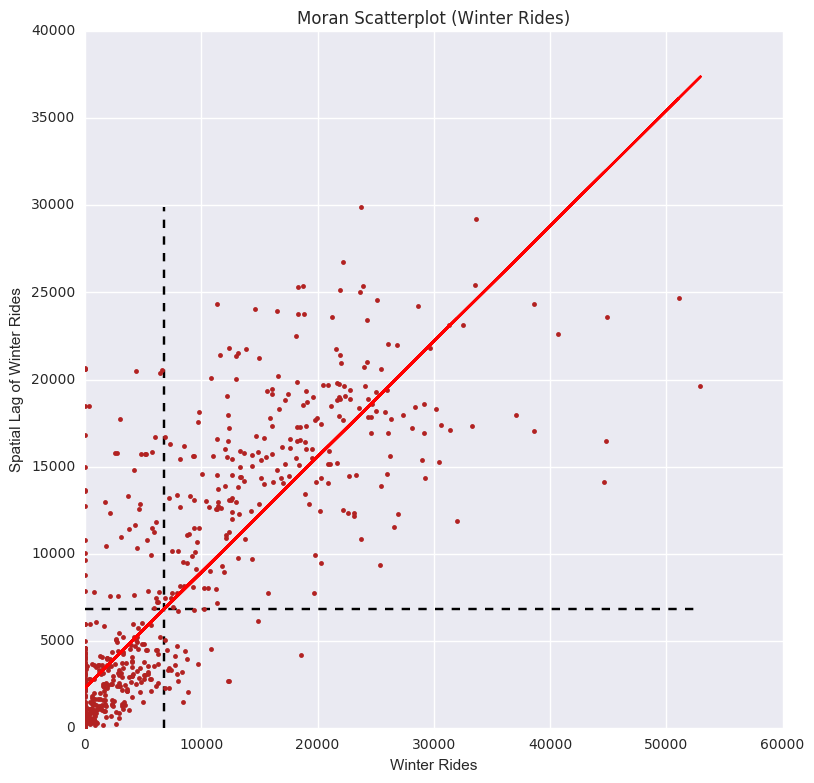

In [165]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(WinterRide, WinterRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a + b*WinterRide, 'r')
plt.title('Moran Scatterplot (Winter Rides)')
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')

### Moran's I

In [166]:
I_MonthlyRide = ps.Moran(WinterRide, qW_CT)

In [167]:
I_MonthlyRide.I, I_MonthlyRide.p_sim

(0.66204419671059411, 0.001)

Thus, the $I$ statistic is $0.662$ for this data, and has a very small $p$ value. 

In [168]:
I_MonthlyRide.sim[0:10]

array([-0.01415042, -0.02030386, -0.00130015,  0.00010256,  0.01464588,
        0.01177737,  0.00394647, -0.00500341,  0.00425931,  0.00355826])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [169]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

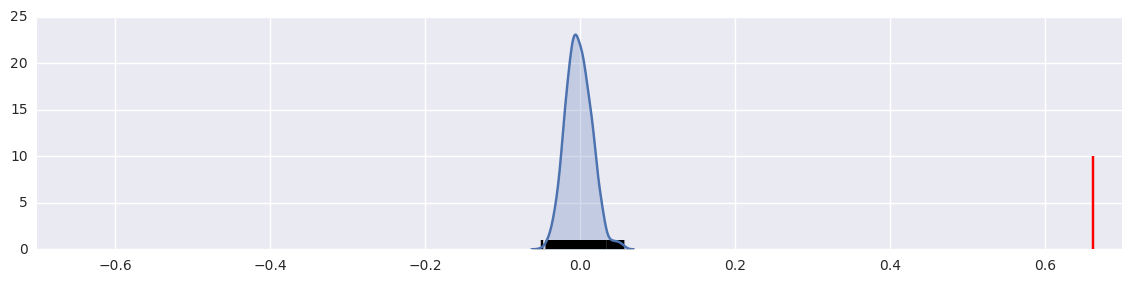

In [170]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

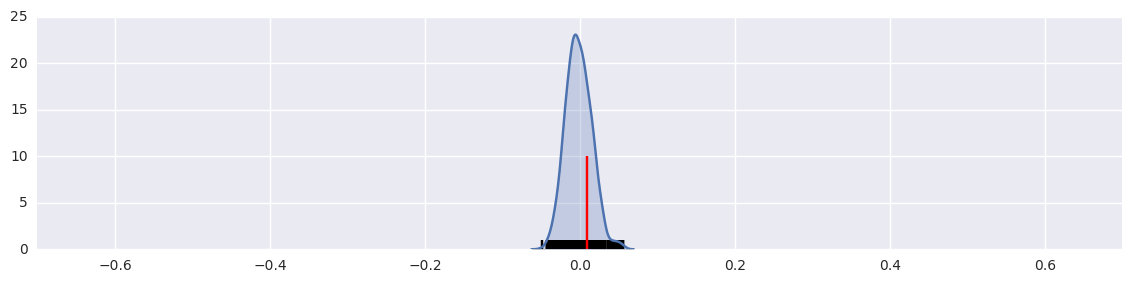

In [171]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [172]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT,permutations=999)

In [173]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([-0.        , -0.3153042 , -0.00110645, -0.00100209, -0.06082761]),
 array([ 0.001,  0.129,  0.473,  0.469,  0.464]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [174]:
sigs = WinterRide[LMo_WinterRide.p_sim <= .001]
W_sigs = WinterRideLag[LMo_WinterRide.p_sim <= .001]
insigs = WinterRide[LMo_WinterRide.p_sim > .001]
W_insigs = WinterRideLag[LMo_WinterRide.p_sim > .001]

### Plot Signficant LISA

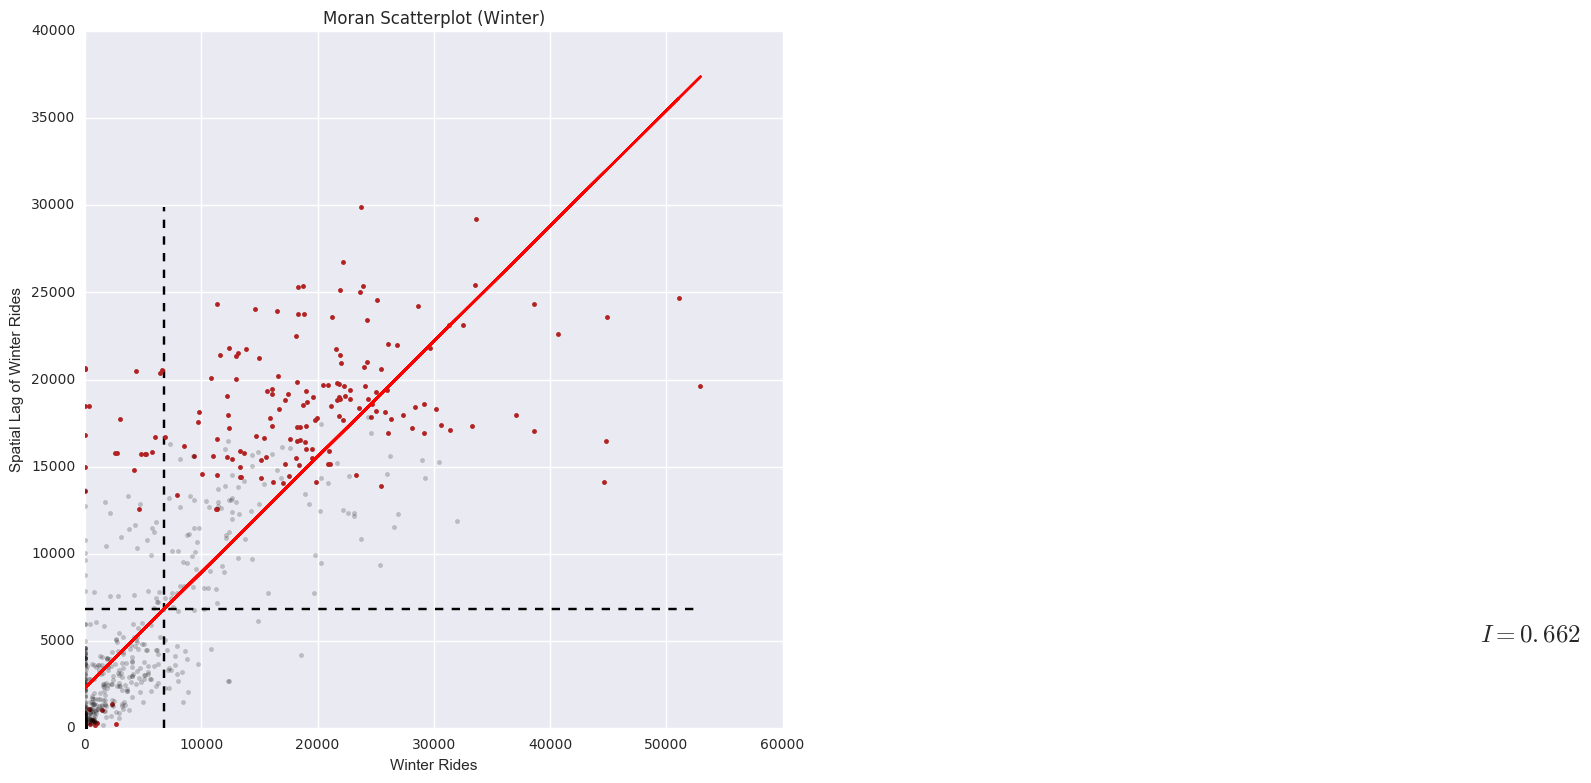

In [175]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a + b*WinterRide, 'r')
plt.title('Moran Scatterplot (Winter)')
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')


### Hot and Cold spots 

In [176]:
sig = LMo_WinterRide.p_sim < 0.01
hotspots = LMo_WinterRide.q==1 * sig
coldspots = LMo_WinterRide.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 195
Number of Coldspots: 215


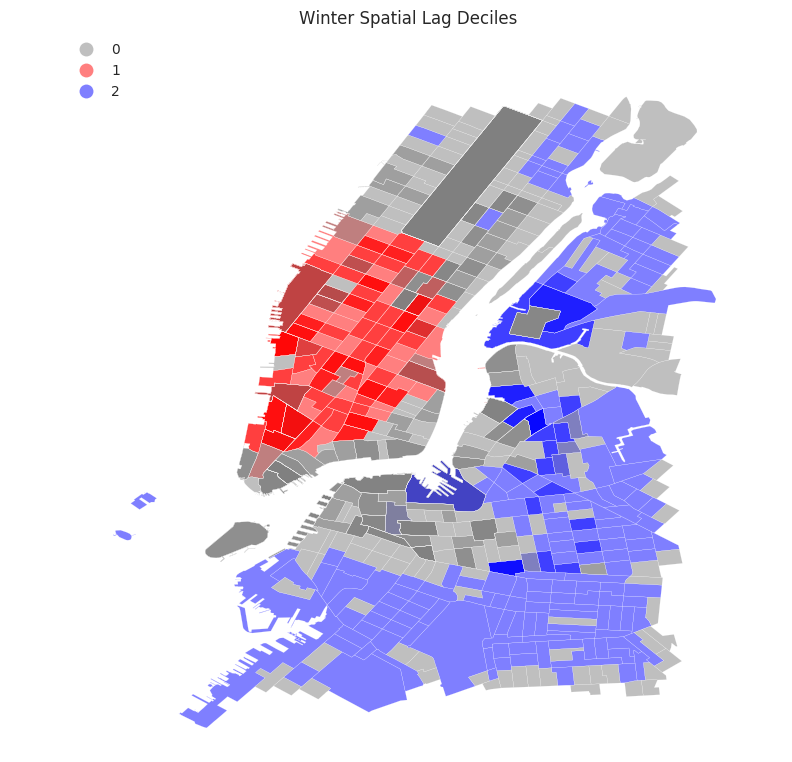

In [177]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Spatial Lag Deciles")

##### Figure 2: Local spacial autocorrelation for winter Citibike Rides; shown as hot spots and cold spots throughout New York City